In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange
from numba import njit, prange

import torch
from torch import nn


from data import addition_dataset

source = "../source"
sys.path.append(source)

from preprocessing import OneHot, Encoding
from compilation import Compiler, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history
from visualization.animation import SliderAnimation
from visualization.activations import ActivationsAnimation
from visualization.automata import AutomatonAnimation
from visualization.epochs import EpochAnimation

import publication

is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


In [2]:
symbols = [str(n) for n in range(10)] + ["+", " "]
onehot = OneHot(symbols)


class SequenceEncoder(Encoding):
    def __init__(self, single_encoder: Encoding):
        self._decoding = lambda x: x
        self.single_encoder = single_encoder

    # @property
    # def symbols(self) -> list:
    #     return None

    # def _update_decoding(self, encoding):
    #     pass

    def __call__(self, data):
        encoded = [self.single_encoder(char) for char in data]
        encoded = encoded[::-1]  # decoded in reverse for better computation
        return encoded

    def decode(self, enc_data):
        enc_data = enc_data.to("cpu").detach()
        decoded = [self.single_encoder.decode(vec) for vec in enc_data]
        decoded = "".join(decoded)
        decoded = decoded[::-1]
        return decoded


encoder = SequenceEncoder(onehot)

In [3]:
## Generate data

full_length = 100
max_train_length = 20
test_length = 30

test_data = addition_dataset(
    device, encoder, n_datapoints=100, seq_len=[test_length], full_length=full_length
)

In [4]:
## Define model


class Model(nn.Module):
    def __init__(self, device, input_size, hidden_size, output_size, num_layers=1):
        super().__init__()
        self.lstm_encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
        )
        self.lstm_decoder = nn.LSTM(
            input_size=hidden_size * 2,
            hidden_size=hidden_size,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
        )
        self.linear = nn.Linear(hidden_size * 2, output_size)

        self.to(device)

    def forward(self, x):
        x, _ = self.lstm_encoder(x)
        x, _ = self.lstm_decoder(x)
        x = self.linear(x)
        return x


model = Model(
    device,
    input_size=len(symbols),
    hidden_size=100,
    num_layers=1,
    output_size=len(symbols),
)

In [5]:
def predict(input, model):
    out = model(input)
    pred = torch.argmax(out, axis=1).int()
    string = "".join([symbols[index] for index in pred])

    string = string[::-1]
    return string


def score(dataset, model):
    count = 0
    n_datapoints = len(dataset)
    for n in prange(n_datapoints):
        x, y = dataset[n]
        target = encoder.decode(y)
        prediction = predict(x, model)
        if target == prediction:
            count += 1
    acc = count / len(dataset)
    return acc

In [6]:
# model = torch.load("model.pt")

In [7]:
train_losses, test_losses, train_scores, test_scores = [], [], [], []

In [156]:
## Train

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
loss_fn = nn.MSELoss()

n_epochs = 5000

for epoch in range(n_epochs):
    # Generate data
    train_data = addition_dataset(
        device,
        encoder,
        n_datapoints=1000,
        seq_len=[x for x in range(3, max_train_length) if x != test_length],
        full_length=full_length,
    )
    train_loader = torch.utils.data.DataLoader(train_data, shuffle=True, batch_size=32)

    # Validation
    if epoch % 50 == 0:
        model.eval()
        with torch.no_grad():
            y_pred = model(train_data.tensors[0])
            train_rmse = np.sqrt(loss_fn(y_pred, train_data.tensors[1]).cpu())
            y_pred = model(test_data.tensors[0])
            test_rmse = np.sqrt(loss_fn(y_pred, test_data.tensors[1]).cpu())
            train_score = score(
                torch.utils.data.Subset(train_data, np.arange(100)), model
            )
            test_score = score(test_data, model)
            train_losses.append(train_rmse)
            test_losses.append(test_rmse)
            train_scores.append(train_score)
            test_scores.append(test_score)
        print(
            f"Epoch {epoch}: train RMSE {train_rmse:.4f}, test RMSE {test_rmse:.4f}, train score {train_score:.2f}, test score {test_score:.2f}"
        )

    # Train
    model.train()
    for X_batch, y_batch in train_loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

Epoch 0: train RMSE 0.0094, test RMSE 0.0941, train score 0.94, test score 0.36
Epoch 50: train RMSE 0.0078, test RMSE 0.0924, train score 0.98, test score 0.37
Epoch 100: train RMSE 0.0083, test RMSE 0.0925, train score 0.99, test score 0.36
Epoch 150: train RMSE 0.0071, test RMSE 0.0920, train score 0.96, test score 0.37
Epoch 200: train RMSE 0.0073, test RMSE 0.0927, train score 0.96, test score 0.37
Epoch 250: train RMSE 0.0070, test RMSE 0.0930, train score 0.99, test score 0.37
Epoch 300: train RMSE 0.0081, test RMSE 0.0931, train score 0.98, test score 0.36


KeyboardInterrupt: 

In [ ]:
# torch.save(model, "model.pt")

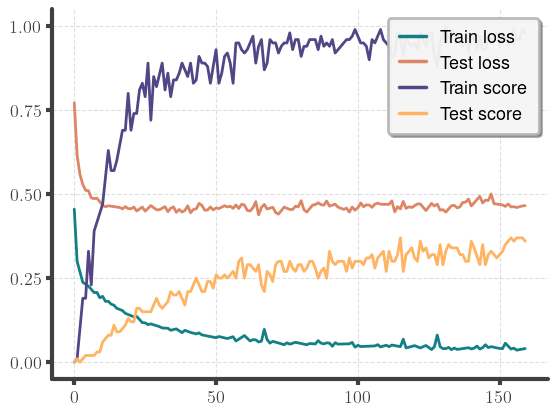

In [157]:
## Plot loss curves
c = 5
publication.set_color_mixed()
plt.plot(c * np.array(train_losses), label="Train loss")
plt.plot(c * np.array(test_losses), label="Test loss")
plt.plot(train_scores, label="Train score")
plt.plot(test_scores, label="Test score")
plt.legend()
publication.plt_show()

In [164]:
int_a = 788778
int_b = 878787878
target = int_a + int_b
example = f"{int_a}+{int_b}"

print(f"Example length: {len(example)}")

computation_length = len(example) + full_length
example = example + " " * (computation_length - len(example))
encoded = torch.tensor(encoder(example), device=device, dtype=torch.float32)
prediction = predict(encoded, model)

print(f"input: {example}")
print(f"target: {target}")
print(f"prediction: {prediction}")
print("Correct!" if int(prediction) == target else "Wrong!")

Example length: 16
input: 788778+878787878                                                                                                    
target: 879576656
prediction: 879576656                                                                                                           
Correct!


100%|██████████| 98/98 [01:03<00:00,  1.54it/s]


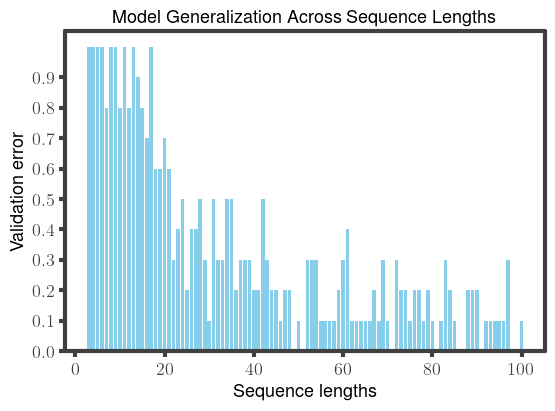

In [17]:
## Check for large sequence length generalization

# Evaluate model generalization for sequences of varying lengths
N = 100
val_scores = []
for n in trange(3, N + 1):
    val_data = addition_dataset(
        device, encoder, n_datapoints=10, seq_len=[n], full_length=full_length
    )
    val_score = score(val_data, model)
    val_scores.append(val_score)

# Visualize validation error for varying sequence lengths
publication.set_color_mixed()
fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes([0.1, 0.1, 0.8, 0.8])
ax.bar(np.arange(3, N + 1), val_scores, color="skyblue")
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_title("Model Generalization Across Sequence Lengths")
ax.set_yticks(np.arange(0, 1, 0.1))
publication.pub_show()